In [12]:
# 1. Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

In [2]:
data = pd.read_csv('spotify_songs.csv')
data

In [3]:
data.shape

(32833, 23)

In [4]:
data.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')

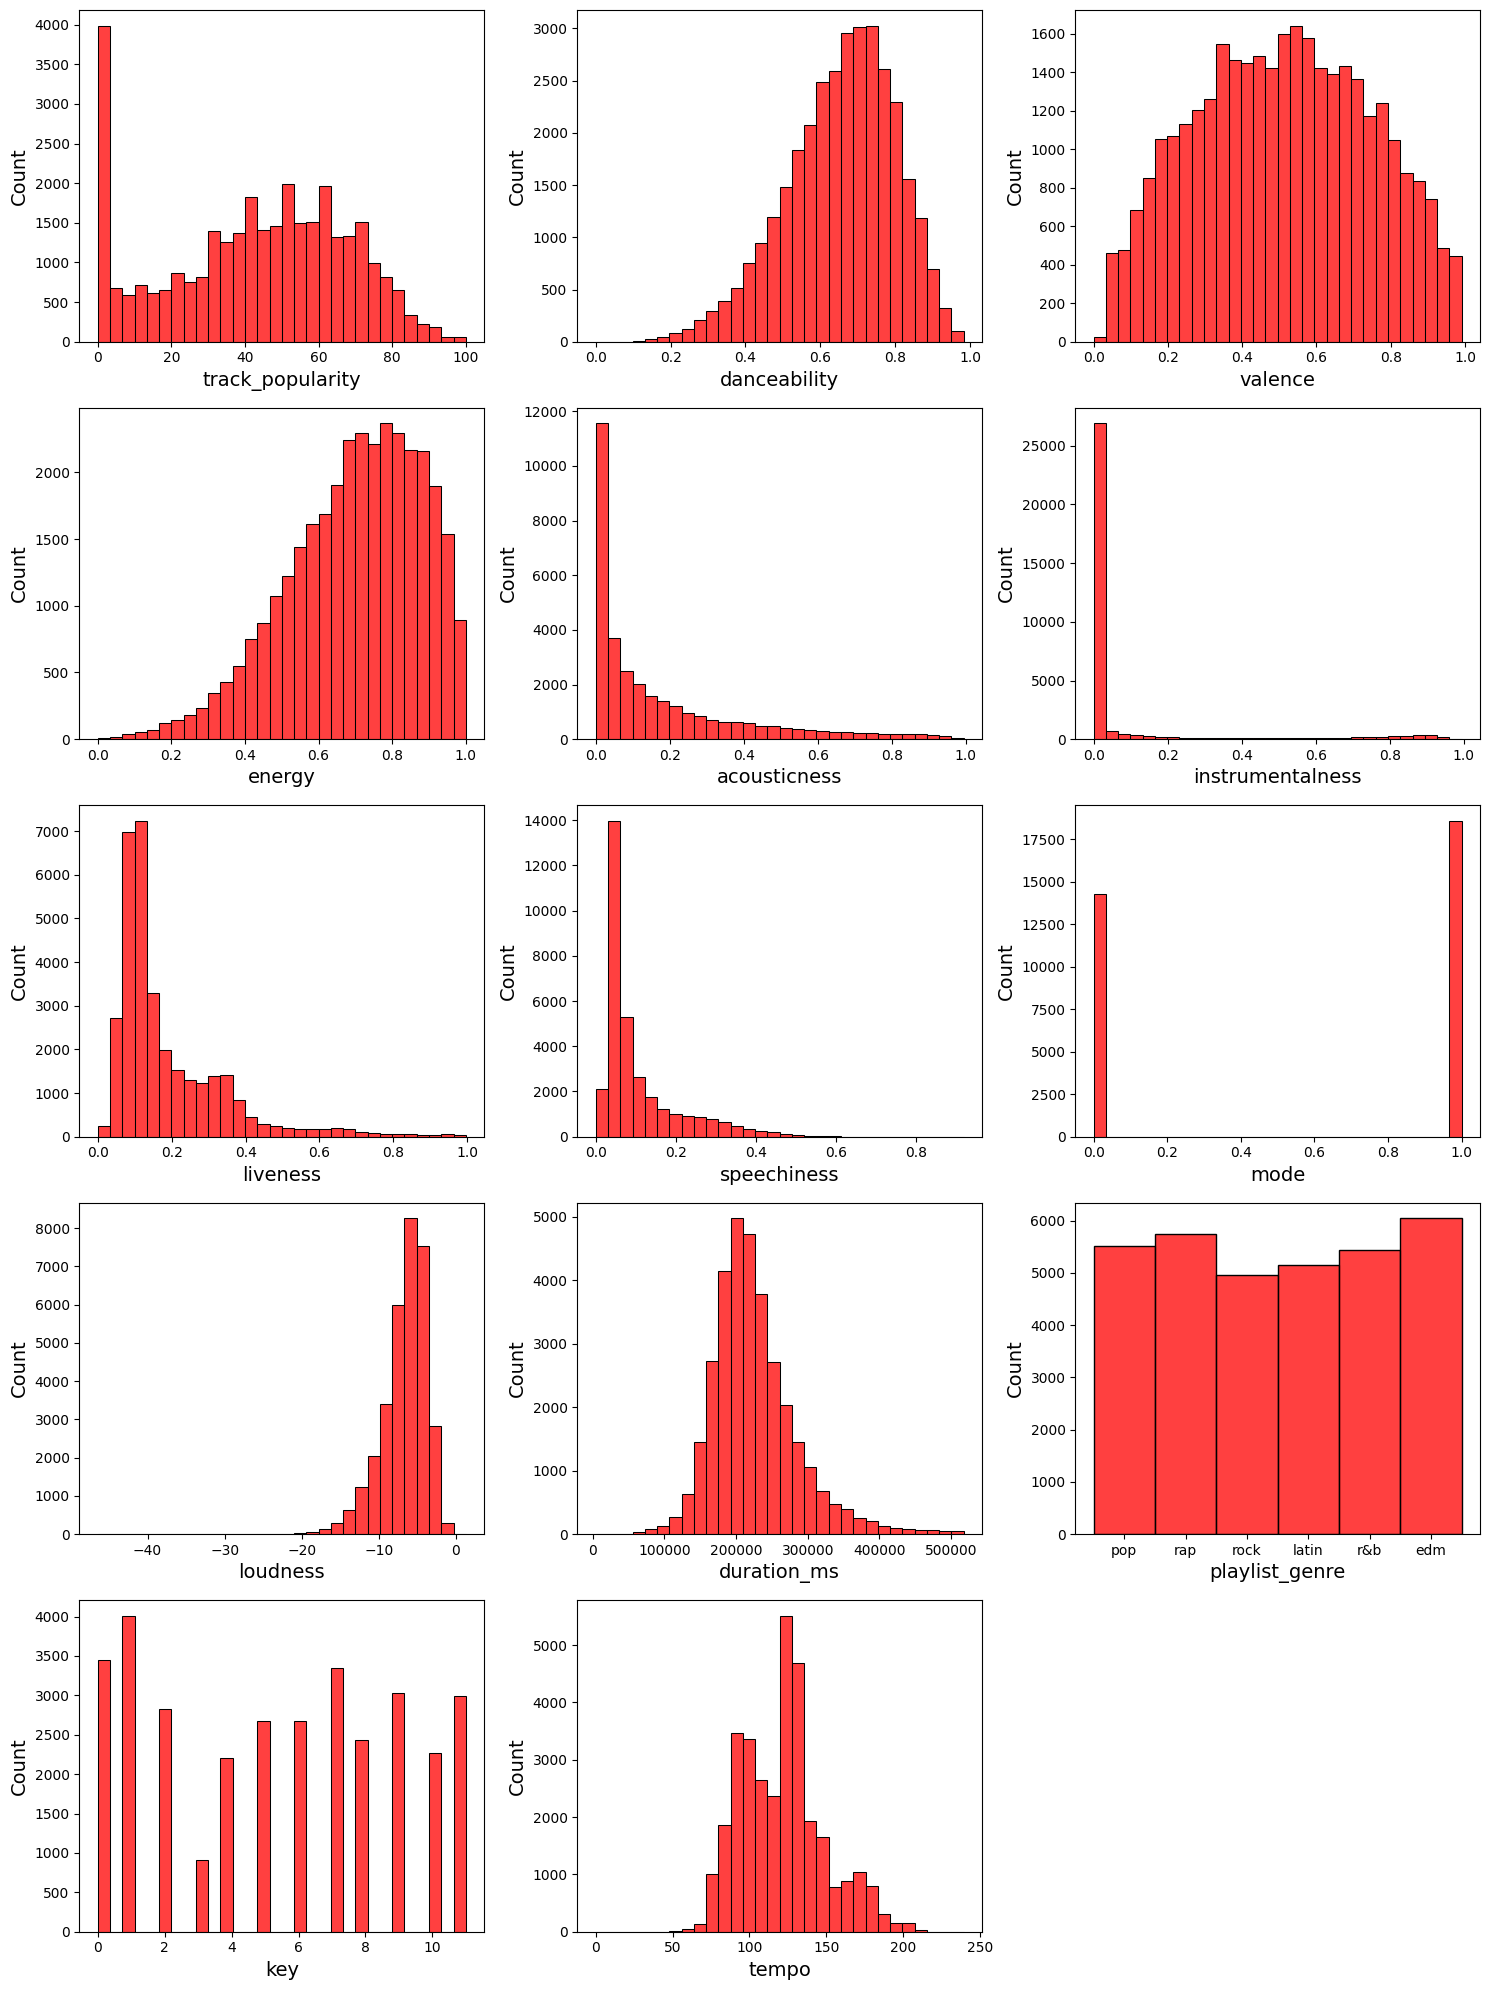

In [26]:
columns_to_plot = ['track_popularity', 'danceability', 'valence', 'energy', 'acousticness',
                   'instrumentalness', 'liveness', 'speechiness', 'mode',
                   'loudness', 'duration_ms', 'playlist_genre', 'key', 'tempo']

plt.figure(figsize=(15, 20))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(5, 3, i)
    sns.histplot(data=data, x=column, bins=30, color='red')
    plt.xlabel(column, fontsize=14)
    plt.ylabel("Count", fontsize=14)

plt.tight_layout()
plt.show()

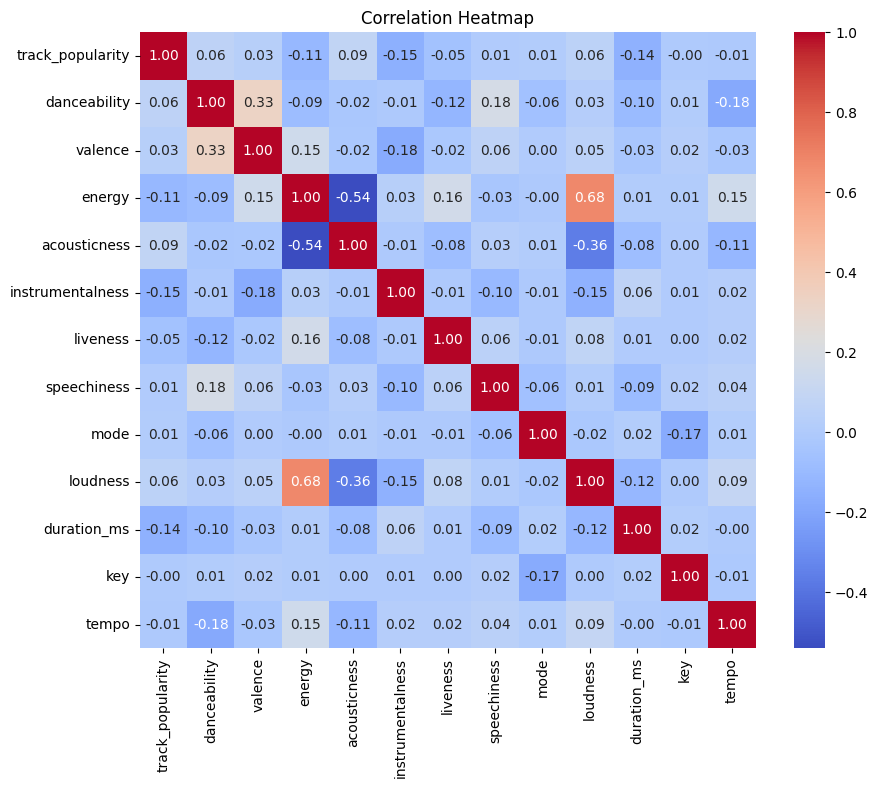

In [25]:
columns_to_correlate = ['track_popularity', 'danceability', 'valence', 'energy', 'acousticness',
                   'instrumentalness', 'liveness', 'speechiness', 'mode',
                   'loudness', 'duration_ms', 'key', 'tempo']

correlation_matrix = data[columns_to_correlate].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)

plt.title("Correlation Heatmap")
plt.show()

In [5]:
# Уберём столбцы, не несущие числовую информацию
drop_cols = ['id', 'name', 'release_date', 'track_href', 'analysis_url']
available = [c for c in drop_cols if c in data.columns]

# Целевая переменная
y = data['track_popularity']

# Фичи: артисты + числовые признаки
df_features = data.drop(columns=available + ['track_popularity'])
# Сохраняем artists отдельно
equals = ['track_artist']
cat = df_features[equals]
num = df_features.select_dtypes(include=[np.number]).fillna(df_features.select_dtypes(include=[np.number]).median())
X_full = pd.concat([cat, num], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42
)
print(f"Train: {X_train.shape[0]} записей, Test: {X_test.shape[0]} записей")

Train: 26266 записей, Test: 6567 записей


In [7]:
# Вычисляем среднюю популярность по артистам
artist_mean = pd.concat([X_train['track_artist'], y_train], axis=1).groupby('track_artist')['track_popularity'].mean()
# Добавляем новую фичу
def add_artist_mean(df):
    df = df.copy()
    df['artist_popularity_mean'] = df['track_artist'].map(artist_mean)
    # Для новых артистов заполняем глобальным средним
    df['artist_popularity_mean'] = df['artist_popularity_mean'].fillna(artist_mean.mean())
    return df.drop(columns=['track_artist'])

X_train = add_artist_mean(X_train)
X_test = add_artist_mean(X_test)

print(f"Train features: {X_train.shape[1]} колонок, Test features: {X_test.shape[1]} колонок")

Train features: 13 колонок, Test features: 13 колонок


In [8]:
## 5. Базовые модели: обучение и оценка на одном разбиении
## Используем функцию для подсчёта MAE, RMSE, R2. Масштабируем признаки для чувствительных к масштабированию алгоритмов.

def eval_on_split(model, X_tr, X_te, y_tr, y_te, scale=False):
    if scale:
        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X_tr)
        X_te = scaler.transform(X_te)
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    return {
        'MAE': mean_absolute_error(y_te, preds),
        'RMSE': np.sqrt(mean_squared_error(y_te, preds)),
        'R2': r2_score(y_te, preds)
    }

models = {
    'LinearRegression': (LinearRegression(), True),
    'DecisionTree': (DecisionTreeRegressor(random_state=42), False),
    'RandomForest': (RandomForestRegressor(n_estimators=100, random_state=42), False),
    'GradientBoosting': (GradientBoostingRegressor(n_estimators=100, random_state=42), False),
    'MLP': (MLPRegressor(max_iter=300, random_state=42), True)
}

base_results = {name: eval_on_split(m, X_train, X_test, y_train, y_test, scale)
                for name, (m, scale) in models.items()}
res_base = pd.DataFrame(base_results).T
print("### Базовые результаты (Train/Test)")
print(res_base)

### Базовые результаты (Train/Test)
                        MAE       RMSE        R2
LinearRegression  15.800085  21.088959  0.283746
DecisionTree      16.832923  24.885389  0.002654
RandomForest      14.096169  19.868409  0.364255
GradientBoosting  15.709543  20.929110  0.294563
MLP               15.750192  20.981725  0.291011


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [9]:
## 6. Кросс-валидация (3-fold)
## Оцениваем стабильность MAE через CV с Pipeline.

cv_results = {}
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
for name, (model, scale) in models.items():
    steps = []
    if scale:
        steps.append(('scaler', StandardScaler()))
    steps.append(('model', model))
    pipe = Pipeline(steps)
    scores = cross_val_score(pipe, pd.concat([X_train, X_test]), pd.concat([y_train, y_test]),
                             cv=3, scoring=mae_scorer, n_jobs=-1)
    cv_results[name] = {'MAE_mean': -scores.mean(), 'MAE_std': scores.std()}

res_cv = pd.DataFrame(cv_results).T
print("### Результаты кросс-валидации (MAE)")
print(res_cv)

### Результаты кросс-валидации (MAE)
                   MAE_mean   MAE_std
LinearRegression  12.143172  1.230994
DecisionTree      14.889175  0.508452
RandomForest      11.206439  1.001751
GradientBoosting  12.200672  1.161904
MLP               12.359724  1.134579


In [10]:
## 7. Подбор гиперпараметров (GridSearchCV)
## Подбираем лучшие сетки для RandomForest, GradientBoosting, MLP по MAE.

grid_params = {
    'RandomForest': {'model__n_estimators': [100, 200], 'model__max_depth': [None, 10, 20]},
    'GradientBoosting': {'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5]},
    'MLP': {'model__hidden_layer_sizes': [(50,), (100,)], 'model__alpha': [0.0001, 0.001]}
}

best_models = {}
for name in ['RandomForest', 'GradientBoosting', 'MLP']:
    model, scale = models[name]
    steps = [('scaler', StandardScaler())] if scale else []
    steps.append(('model', model))
    pipe = Pipeline(steps)
    gs = GridSearchCV(pipe, grid_params[name], cv=5,
                      scoring='neg_mean_absolute_error', n_jobs=-1)
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    print(f"{name} best MAE: {-gs.best_score_:.3f}, params: {gs.best_params_}")

RandomForest best MAE: 10.113, params: {'model__max_depth': None, 'model__n_estimators': 200}
GradientBoosting best MAE: 11.012, params: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 200}
MLP best MAE: 11.154, params: {'model__alpha': 0.0001, 'model__hidden_layer_sizes': (50,)}


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [27]:
## 8. Оценка оптимизированных моделей на Test

tuned_results = {name: eval_on_split(pipe.named_steps['model'], X_train, X_test, y_train, y_test, models[name][1])
                 for name, pipe in best_models.items()}
res_tuned = pd.DataFrame(tuned_results).T
print("### Результаты оптимизированных моделей (Test)")
print(res_tuned)

### Результаты оптимизированных моделей (Test)
                        MAE       RMSE        R2
RandomForest      14.046960  19.818752  0.367429
GradientBoosting  15.537208  20.668208  0.312041
MLP               15.766580  21.035006  0.287406


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


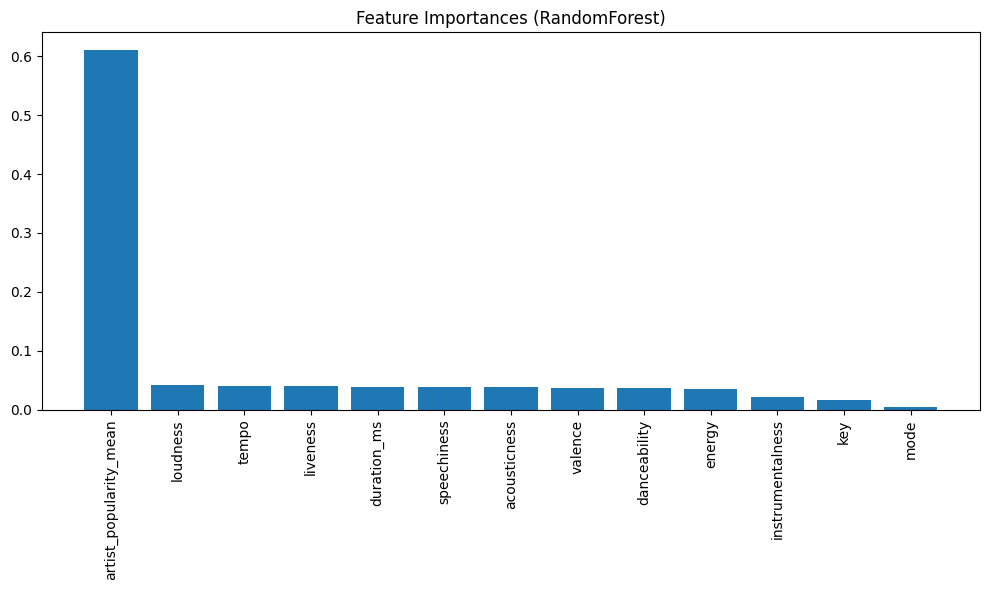

In [28]:
## 9. Важность признаков для RandomForest

rf_model = best_models['RandomForest'].named_steps.get('model')
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Feature Importances (RandomForest)')
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()